In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []
wrat = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [194]:
# Load timeseries and calculate partial correlation

# from nilearn.connectome import ConnectivityMeasure
import numpy as np

# cm = ConnectivityMeasure(kind='partial correlation')

def partial(ts):
    # Estimate covariance using approximated LedoitWolf
    I = torch.eye(264).float().cuda()
    C = ts@ts.T+1000*I
    p = torch.linalg.inv(C)
    d = torch.diag(p)
    d = torch.abs(d)
    dinv = 1/(d**0.5)
    p = -p*dinv.unsqueeze(0)*dinv.unsqueeze(1)
    p = (1-I)*p
    a,b = np.triu_indices(264,1)
    return p[a,b]

restfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
nbackfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))
emoidfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_emoid_good_filt.pkl', 'rb'))

restpc = []
nbackpc = []
emoidpc = []

a,b = np.triu_indices(264,1)

for i,sub in enumerate(subids):
    rp = restfilt[sub][ours2orig,:]
    nbp = nbackfilt[sub][ours2orig,:]
    ep = emoidfilt[sub][ours2orig,:]
    rp = partial(torch.from_numpy(rp).float().cuda()).detach().cpu().numpy()
    nbp = partial(torch.from_numpy(nbp).float().cuda()).detach().cpu().numpy()
    ep = partial(torch.from_numpy(ep).float().cuda()).detach().cpu().numpy()
    restpc.append(rp)
    nbackpc.append(nbp)
    emoidpc.append(ep)
    if i % 50 == 0:
        print(f'Done {i}')

restpc = np.stack(restpc)
nbackpc = np.stack(nbackpc)
emoidpc = np.stack(emoidpc)

print([a.shape for a in [restpc, nbackpc, emoidpc]])

Done 0
Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Done 850
Done 900
Done 950
Done 1000
Done 1050
Done 1100
Done 1150
[(1193, 34716), (1193, 34716), (1193, 34716)]


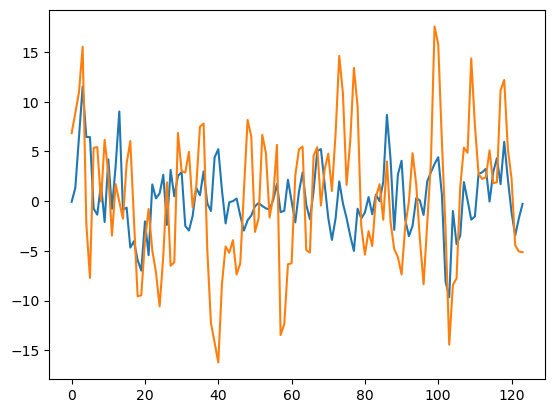

In [216]:
# Testing for later constrained generation of timeseries

for i,sub in enumerate(subids):
    rp = restfilt[sub][ours2orig,:]
    nbp = nbackfilt[sub][ours2orig,:]
    ep = emoidfilt[sub][ours2orig,:]
    if i == 0:
        break

r = 5*np.random.normal(size=(124))
for i in range(len(r)-2):
    r[i] = r[i]+r[i+1]
plt.plot(rp[0])
plt.plot(r)

In [217]:
# Save custom partial correlations

for i,sub in enumerate(subids):
    np.save(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/pc/{sub}_task-rest_pc.npy', restpc[i])
    np.save(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/pc/{sub}_task-nback_pc.npy', nbackpc[i])
    np.save(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/pc/{sub}_task-emoid_pc.npy', emoidpc[i])
    if i % 100 == 0:
        print(f'Done {i}')

print('Done')

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
Done 1100
Done


In [218]:
# Calculate regularizers

from sklearn.linear_model import LogisticRegression, Ridge

age_reg = Ridge(alpha=100).fit(np.concatenate([restpc, nbackpc, emoidpc]), np.concatenate([age, age, age]))
age_w = age_reg.coef_
age_i = age_reg.intercept_

print('Done age')

sex_reg = LogisticRegression(C=100).fit(np.concatenate([restpc, nbackpc, emoidpc]), np.concatenate([sex, sex, sex]))
sex_w = sex_reg.coef_[0]
sex_i = sex_reg.intercept_[0]

print('Done sex')

race_reg = LogisticRegression(C=100).fit(np.concatenate([restpc, nbackpc, emoidpc]), np.concatenate([race, race, race]))
race_w = race_reg.coef_[0]
race_i = race_reg.intercept_[0]

print('Done race')

rest_reg = LogisticRegression(C=100, max_iter=500).fit(np.concatenate([restpc, nbackpc, emoidpc]), 
                                         np.concatenate([np.ones(1193), np.zeros(1193), np.zeros(1193)]))
rest_w = rest_reg.coef_[0]
rest_i = rest_reg.intercept_[0]

print('Done rest')

nback_reg = LogisticRegression(C=100, max_iter=500).fit(np.concatenate([restpc, nbackpc, emoidpc]), 
                                         np.concatenate([np.zeros(1193), np.ones(1193), np.zeros(1193)]))
nback_w = nback_reg.coef_[0]
nback_i = nback_reg.intercept_[0]

print('Done nback')

emoid_reg = LogisticRegression(C=100, max_iter=500).fit(np.concatenate([restpc, nbackpc, emoidpc]), 
                                         np.concatenate([np.zeros(1193), np.zeros(1193), np.ones(1193)]))
emoid_w = emoid_reg.coef_[0]
emoid_i = emoid_reg.intercept_[0]

print('Done emoid')

Done age
Done sex
Done race
Done rest
Done nback
Done emoid


In [219]:
# Save regularizers

dct = dict(
    age_w=age_w,
    age_i=age_i,
    sex_w=sex_w,
    sex_i=sex_i,
    race_w=race_w,
    race_i=race_i,
    rest_w=rest_w,
    rest_i=rest_i,
    nback_w=nback_w,
    nback_i=nback_i,
    emoid_w=emoid_w,
    emoid_i=emoid_i
)

pickle.dump(dct, open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/pc_regularizers.pkl', 'wb'))

print('Done')

Done


In [220]:
age_w = torch.from_numpy(age_w).float().cuda()
sex_w = torch.from_numpy(sex_w).float().cuda()
race_w = torch.from_numpy(race_w).float().cuda()
rest_w = torch.from_numpy(rest_w).float().cuda()
nback_w = torch.from_numpy(nback_w).float().cuda()
emoid_w = torch.from_numpy(emoid_w).float().cuda()

print('Done')

Done


In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, age, sex, race):
    age = age - torch.mean(age)
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    agep = torch.einsum('n,nz->z', age, z)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_age = rmse(agep, tgt)
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    return loss_age + loss_sex + loss_race

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(restpc.shape[-1], 30)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-6)

restpc_t = torch.from_numpy(restpc).float().cuda()
nbackpc_t = torch.from_numpy(nbackpc).float().cuda()
emoidpc_t = torch.from_numpy(emoidpc).float().cuda()
age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()

nepochs = 4000
pperiod = 50

ce = nn.CrossEntropyLoss()

for e in range(nepochs):
    if e % 3 == 0:
        tidx = 0
        x = restpc_t
    elif e % 3 == 1:
        tidx = 1
        x = nbackpc_t
    else:
        tidx = 2
        x = emoidpc_t
    task = torch.ones(len(x)).long().cuda()
    # Reconstruct
    optim.zero_grad()
    z = vae.enc(x)
    y = vae.dec(z, age_t, sex_t, race_t, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    lossC, lossmu, _, _ = latent_loss(z)
    lossDecor = decor_loss(z, age_t, sex_t, race_t)
    lossrec = rmse(x, y)
    # Generate
    tidx = random.randint(0,2)
    ag = torch.ones(100).float().cuda()*torch.randn(1)[0]
    sx = torch.ones(100).long().cuda()*random.randint(0,1)
    rc = torch.ones(100).long().cuda()*random.randint(0,1)
    task = torch.ones(100).long().cuda()
    z = vae.gen(100)
    y = vae.dec(z, ag, sx, rc, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    ag_hat = y@age_w + age_i
    sx_hat = y@sex_w + sex_i
    rc_hat = y@race_w + race_i
    rs_hat = y@rest_w + rest_i
    nb_hat = y@nback_w + nback_i
    em_hat = y@emoid_w + emoid_i
    age_loss = rmse(ag_hat, ag)
    sex_loss = ce(torch.stack([-sx_hat, sx_hat], dim=1), sx)
    race_loss = ce(torch.stack([-rc_hat, rc_hat], dim=1), rc)
    rest_loss = ce(torch.stack([-rs_hat, rs_hat], dim=1), task*(tidx == 0))
    nback_loss = ce(torch.stack([-nb_hat, nb_hat], dim=1), task*(tidx == 1))
    emoid_loss = ce(torch.stack([-em_hat, em_hat], dim=1), task*(tidx == 2))
    (lossC+lossmu+lossrec+lossDecor+0.01*age_loss+0.001*sex_loss+0.001*race_loss+0.01*rest_loss+0.01*nback_loss+0.01*emoid_loss).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossC)} {pretty(lossmu)} {pretty(lossDecor)} *{pretty(lossrec)}* {pretty(age_loss)} {pretty(sex_loss)} {pretty(race_loss)}' + 
             f' {pretty(rest_loss)} {pretty(nback_loss)} {pretty(emoid_loss)}')

print('Done')

0 21.6981 0.0194 0.6362 *0.0862* 1.7988 0.0453 7.598 0.0 0.0054 0.0
50 21.6531 0.0255 0.0236 *0.0831* 0.5363 0.0 0.0 0.0 0.0 0.0
100 21.6002 0.0311 0.0524 *0.0844* 0.1071 0.0 0.0 0.0 0.0 0.0
150 21.5426 0.037 0.0274 *0.0805* 0.0947 0.0 0.0 0.0 0.0 0.0
200 21.4795 0.044 0.0531 *0.0757* 0.0757 0.0 0.0 0.0 0.0 0.0
250 21.4428 0.0492 0.0193 *0.0752* 0.0864 0.0 0.0 0.0 0.0 0.0
300 21.4279 0.0521 0.0072 *0.0704* 0.1462 0.0 0.0 0.0 0.0 0.0
350 21.4197 0.0544 0.0114 *0.0667* 0.2738 0.0 0.0 0.0 0.0 0.0
400 21.4178 0.0552 0.0186 *0.0662* 0.0834 0.0 0.0 0.0 0.0 0.0
450 21.4187 0.0548 0.0078 *0.0613* 0.7122 0.0 0.0 0.0 0.0 0.0
500 21.4174 0.0554 0.0067 *0.059* 0.0634 0.0 0.0 0.0 0.0 0.0
550 21.4166 0.0558 0.0008 *0.0588* 0.3727 0.0 0.0 0.0 0.0 0.0
600 21.4164 0.0559 0.0042 *0.0542* 0.4028 0.0 0.0 0.0 0.0 0.0
650 21.4161 0.0561 0.0026 *0.0532* 0.3754 0.0 0.0 0.0 0.0 0.0
700 21.416 0.0562 0.0017 *0.0531* 0.2602 0.0001 0.0 0.0 0.0 0.0
750 21.4161 0.0562 0.0015 *0.0486* 0.0589 0.0 0.0 0.0 0.0 0.0
800 

In [222]:
# Save VAE

torch.save(vae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/pc_vae_1000_z30_cov6.torch')

print('Done')

Done
